# Hierarchical Attention Network (HAN) with word & sentence level 

This notebook implements the **Hierarchical Attention Network** (HAN) which models both sentence and word-level structures with attention mechanisms.


In [ ]:
!pip install -q transformers torch datasets accelerate scikit-learn

## 📥 Dataset Loading & Hierarchy Simulation

We use the `fetch_20newsgroups` dataset and extract top-level categories from the full class names to simulate a hierarchy (e.g., `comp.graphics → comp`).


In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

In [12]:
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
df = pd.DataFrame({'text': newsgroups.data, 'label': newsgroups.target})
df.head(3)

,text,label
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4


In [14]:
df['target_name'] = [newsgroups.target_names[i] for i in df['label']]
df.head()

,text,label,target_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware


In [ ]:
# Simulate hierarchy by extracting top-level category
df['parent_category'] = df['target_name'].apply(lambda x: x.split('.')[0] if '.' in x else x)
df[['text', 'parent_category', 'target_name']].head(2)

,text,parent_category,target_name
0,I was wondering if anyone out there could enli...,rec,rec.autos
1,A fair number of brave souls who upgraded thei...,comp,comp.sys.mac.hardware


In [23]:
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## ✂️ Text Preprocessing & Tokenization

Texts are tokenized into **sentences** and then **words**. We limit the number of sentences and words per document for computational efficiency.



In [34]:
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
tqdm.pandas()

In [35]:
MAX_SENTS = 15       # max number of sentences per doc
MAX_WORDS = 20       # max number of words per sentence
MAX_VOCAB_SIZE = 20000

# Tokenization
def tokenize_text(text):
    sentences = sent_tokenize(text)
    tokenized = [word_tokenize(sent.lower())[:MAX_WORDS] for sent in sentences[:MAX_SENTS]]
    return tokenized

# Apply tokenization
df['tokens'] = df['text'].progress_apply(tokenize_text)

100%|██████████| 11314/11314 [00:11<00:00, 1001.09it/s]


In [37]:
df.head(2)

,text,label,target_name,parent_category,tokens
0,I was wondering if anyone out there could enli...,7,rec.autos,rec,"[[i, was, wondering, if, anyone, out, there, c..."
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware,comp,"[[a, fair, number, of, brave, souls, who, upgr..."


## 📚 Vocabulary Construction

A vocabulary is created using the top `MAX_VOCAB_SIZE` frequent words. Each word is assigned a unique ID for embedding and encoding.

In [36]:
from collections import Counter

word_counter = Counter()

for doc in df['tokens']:
    for sent in doc:
        word_counter.update(sent)

# Most common words
vocab = ['<PAD>', '<UNK>'] + [word for word, freq in word_counter.most_common(MAX_VOCAB_SIZE - 2)]
word2idx = {word: i for i, word in enumerate(vocab)}

In [70]:
len(vocab)

20000

## 🔢 Document Encoding

Each document is converted to a fixed-size 2D tensor with shape `(MAX_SENTS, MAX_WORDS)`, where each entry is a word index.


In [41]:
def encode_doc(doc, word2idx):
    encoded = np.zeros((MAX_SENTS, MAX_WORDS), dtype=int)
    for i, sent in enumerate(doc[:MAX_SENTS]):
        for j, word in enumerate(sent[:MAX_WORDS]):
            encoded[i][j] = word2idx.get(word, word2idx['<UNK>'])
    return encoded

df['encoded'] = df['tokens'].progress_apply(lambda doc: encode_doc(doc, word2idx))
df.head(2)

100%|██████████| 11314/11314 [00:00<00:00, 13848.17it/s]


,text,label,target_name,parent_category,tokens,encoded
0,I was wondering if anyone out there could enli...,7,rec.autos,rec,"[[i, was, wondering, if, anyone, out, there, c...","[[6, 34, 641, 30, 105, 70, 43, 90, 6372, 59, 2..."
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware,comp,"[[a, fair, number, of, brave, souls, who, upgr...","[[7, 1228, 212, 8, 6882, 6883, 69, 3821, 92, 3..."


## 🎯 Label Encoding

We encode the top-level categories using `LabelEncoder` to prepare for multiclass classification.


In [42]:
from sklearn.preprocessing import LabelEncoder

# We'll classify the parent category (e.g., 'comp', 'rec', etc.)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['parent_category'])

NUM_CLASSES = len(le.classes_)
print("Parent category classes:", list(le.classes_))

Parent category classes: ['alt', 'comp', 'misc', 'rec', 'sci', 'soc', 'talk']


In [43]:
X = np.stack(df['encoded'].values)
y = df['label_enc'].values

print("Input shape:", X.shape)
print("Labels shape:", y.shape)

Input shape: (11314, 15, 20)
Labels shape: (11314,)


## 🧱 Model Architecture: HAN

The model consists of:
- Word-level Bi-GRU with attention
- Sentence-level Bi-GRU with attention
- Fully connected output layer for classification

Each document is processed hierarchically using attention at both levels.


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [45]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, inputs):  # (batch, seq_len, hidden)
        scores = self.attn(inputs).squeeze(-1)  # (batch, seq_len)
        weights = F.softmax(scores, dim=-1)
        weighted = (inputs * weights.unsqueeze(-1)).sum(dim=1)
        return weighted

In [46]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
        super(HAN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.word_gru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.word_attention = Attention(hidden_size * 2)

        self.sent_gru = nn.GRU(hidden_size * 2, hidden_size, bidirectional=True, batch_first=True)
        self.sent_attention = Attention(hidden_size * 2)

        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):  # x: (batch, max_sents, max_words)
        B, S, W = x.size()
        x = x.view(B * S, W)  # (B*S, W)
        embedded = self.embedding(x)  # (B*S, W, embed_dim)

        word_output, _ = self.word_gru(embedded)  # (B*S, W, 2H)
        word_vec = self.word_attention(word_output)  # (B*S, 2H)

        sent_vec = word_vec.view(B, S, -1)  # (B, S, 2H)
        sent_output, _ = self.sent_gru(sent_vec)  # (B, S, 2H)
        doc_vec = self.sent_attention(sent_output)  # (B, 2H)

        return self.fc(doc_vec)

In [47]:
VOCAB_SIZE = len(word2idx)
EMBED_DIM = 100
HIDDEN_SIZE = 50

model = HAN(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASSES)
print(model)

HAN(
  (embedding): Embedding(20000, 100, padding_idx=0)
  (word_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (word_attention): Attention(
    (attn): Linear(in_features=100, out_features=1, bias=True)
  )
  (sent_gru): GRU(100, 50, batch_first=True, bidirectional=True)
  (sent_attention): Attention(
    (attn): Linear(in_features=100, out_features=1, bias=True)
  )
  (fc): Linear(in_features=100, out_features=7, bias=True)
)


In [48]:
from sklearn.model_selection import train_test_split

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.long)
y_tensor = torch.tensor(y, dtype=torch.long)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

## ⚙️ Training Setup

We split the data into training and validation sets. The model is trained using `CrossEntropyLoss` and `Adam` optimizer.


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()

In [50]:
def train_epoch(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for X_batch, y_batch in loop:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = output.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    acc = correct / total
    return total_loss / len(dataloader), acc

In [51]:
def evaluate(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    loop = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)

            total_loss += loss.item()
            preds = output.argmax(1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)

    acc = correct / total
    return total_loss / len(dataloader), acc

## 📈 Training & Evaluation Loops

Custom training and evaluation functions are defined using PyTorch to measure accuracy and loss per epoch.


In [52]:
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    print(f"  🔹 Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f"  🔹 Val   loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")


Epoch 1/5


  🔹 Train loss: 1.4051, accuracy: 0.4430
  🔹 Val   loss: 1.0331, accuracy: 0.6248

Epoch 2/5


  🔹 Train loss: 0.7905, accuracy: 0.7100
  🔹 Val   loss: 0.8095, accuracy: 0.7013

Epoch 3/5


  🔹 Train loss: 0.4679, accuracy: 0.8347
  🔹 Val   loss: 0.8543, accuracy: 0.7194

Epoch 4/5


  🔹 Train loss: 0.2588, accuracy: 0.9114
  🔹 Val   loss: 0.9472, accuracy: 0.7269

Epoch 5/5


  🔹 Train loss: 0.1415, accuracy: 0.9523
  🔹 Val   loss: 1.0787, accuracy: 0.7366


## 🧪 Inference Function

We define a utility function to classify new documents by preprocessing them into tensors and passing through the HAN model.


In [59]:
def preprocess_for_inference(text, word2idx, max_sent_len=10, max_sents=5):
    # Use word2idx for lookup instead of vocab list
    sentences = sent_tokenize(text)
    sentences = sentences[:max_sents]

    word_indices = []
    for sent in sentences:
        tokens = word_tokenize(sent.lower())
        # Use word2idx.get() to get the index, falling back to '<UNK>' index
        # Access '<PAD>' index from word2idx
        indices = [word2idx.get(w, word2idx['<UNK>']) for w in tokens[:max_sent_len]]
        padded = indices + [word2idx['<PAD>']] * (max_sent_len - len(indices))
        word_indices.append(padded)

    while len(word_indices) < max_sents:
        word_indices.append([word2idx['<PAD>']] * max_sent_len)

    return torch.tensor([word_indices], dtype=torch.long)  # (1, max_sents, max_sent_len)

def predict(model, text, word2idx, label_names):
    # Pass word2idx to preprocess_for_inference
    model.eval()
    x = preprocess_for_inference(text, word2idx).to(device)

    with torch.no_grad():
        output = model(x)
        pred_idx = output.argmax(1).item()
        return label_names[pred_idx]

# Use word2idx when calling predict
sample_text = """Apple has unveiled its latest iPhone with enhanced camera features and better battery life.
Analysts believe this will help Apple boost its market share in Asia."""
label_names = list(le.classes_)
# Call predict with word2idx
predicted_label = predict(model, sample_text, word2idx, label_names)
print(f"🧠 Predicted Topic: {predicted_label}")

🧠 Predicted Topic: misc


## Vizualize Attention


In [60]:
class HAN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_classes):
        super(HAN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.word_rnn = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
        self.word_attention = nn.Linear(2 * hidden_size, 1)

        self.sent_rnn = nn.GRU(2 * hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.sent_attention = nn.Linear(2 * hidden_size, 1)

        self.fc = nn.Linear(2 * hidden_size, num_classes)

    def forward(self, x, return_attention=False):
        batch_size, num_sents, num_words = x.size()
        x = x.view(-1, num_words)  # (B * S, W)
        x_embed = self.embed(x)    # (B * S, W, D)

        h_word, _ = self.word_rnn(x_embed)  # (B*S, W, 2H)
        word_attn_weights = torch.softmax(self.word_attention(h_word), dim=1)  # (B*S, W, 1)
        s = torch.sum(word_attn_weights * h_word, dim=1)  # (B*S, 2H)
        s = s.view(batch_size, num_sents, -1)  # (B, S, 2H)

        h_sent, _ = self.sent_rnn(s)  # (B, S, 2H)
        sent_attn_weights = torch.softmax(self.sent_attention(h_sent), dim=1)  # (B, S, 1)
        v = torch.sum(sent_attn_weights * h_sent, dim=1)  # (B, 2H)

        out = self.fc(v)

        if return_attention:
            return out, word_attn_weights.view(batch_size, num_sents, num_words), sent_attn_weights
        else:
            return out


In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_attention(text, word_attn, sent_attn, max_sents=5, max_words=10):
    sents = sent_tokenize(text)[:max_sents]
    words_list = [word_tokenize(sent.lower())[:max_words] for sent in sents]

    fig, axs = plt.subplots(len(words_list), 1, figsize=(10, 2 * len(words_list)))
    if len(words_list) == 1:
        axs = [axs]

    for i, words in enumerate(words_list):
        if i >= word_attn.shape[1]:
            break
        weights = word_attn[0, i, :len(words)].cpu().numpy()
        sns.heatmap([weights], annot=[words], fmt='', cmap='YlGnBu', ax=axs[i])
        axs[i].set_title(f"Sentence {i+1} (Weight: {sent_attn[0, i, 0].item():.2f})")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


In [62]:
def predict_with_attention(model, text, vocab, label_names):
    model.eval()
    x = preprocess_for_inference(text, vocab).to(device)

    with torch.no_grad():
        output, word_attn, sent_attn = model(x, return_attention=True)
        pred_idx = output.argmax(1).item()
        return label_names[pred_idx], word_attn, sent_attn


🧠 Predicted Label: alt


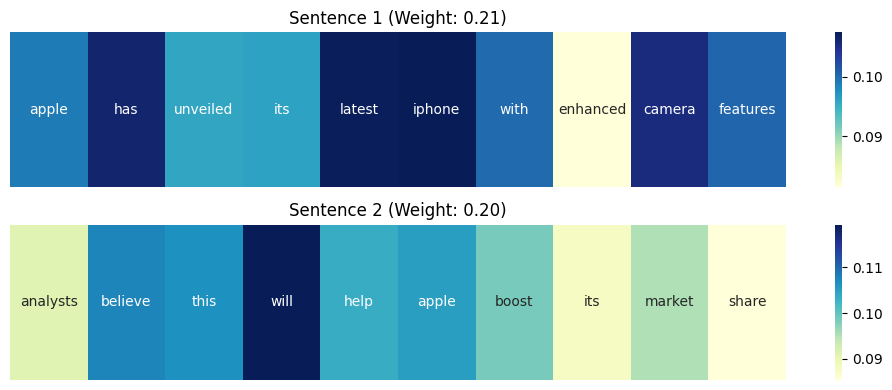

In [65]:
def predict_with_attention(model, text, word2idx, label_names):
    model.eval()
    # Pass the word2idx dictionary instead of the vocab list
    x = preprocess_for_inference(text, word2idx).to(device)

    with torch.no_grad():
        # The model instance needs to be from the class definition
        # that supports return_attention=True
        output, word_attn, sent_attn = model(x, return_attention=True)
        pred_idx = output.argmax(1).item()
        return label_names[pred_idx], word_attn, sent_attn

# Now call predict_with_attention with the correct word2idx dictionary
text = """Apple has unveiled its latest iPhone with enhanced camera features and better battery life.
Analysts believe this will help Apple boost its market share in Asia."""


model = HAN(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE, NUM_CLASSES).to(device)


label, word_attn, sent_attn = predict_with_attention(model, text, word2idx, label_names)
print(f"🧠 Predicted Label: {label}")

visualize_attention(text, word_attn, sent_attn)